## Introduction

This tutorial is focused on learning the basics of NetworkX to analyze and visualize social media data. You will learn basic functions for NetworkX, import data from an existing Twitter dataset, create a graph of a network, and run functions to understand more about the network. We will also be learning basics of graph theory in order to improve our understanding of graph data. Lastly, we cover visualization using matplotlib. We will not go over algorithms such as PageRank because they are relatively easy to implement in NetworkX. Instead, we focus more on the process of loading in data, analyzing our network, and visualizing it.

We will cover the following topics in this tutorial:
- [Dataset: #GifHistory](#Dataset-#GifHistory)
- [Learning NetworkX](#Learning-NetworkX)
- [Loading in Twitter data](#Loading-in-Twitter-data)
- [Exploring retweets of #GifHistory](#Exploring-retweets-of-#GifHistory)
- [Centrality measures of networks](#Centrality-measures-of-networks)
- [Visualization](#Visualization)

## Dataset: #GifHistory

#GifHistory is a hashtag started on Twitter in February 2018 where people post a gif and members on Twitter attempt to find where the gif came from. It started with the following tweet:

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">I wanna create a thread called <a href="https://twitter.com/hashtag/GifHistory?src=hash&amp;ref_src=twsrc%5Etfw">#GifHistory</a>. Send a gif that you want to know the backstory to and we&#39;ll try to find the original video.<br><br>First up: <a href="https://t.co/KyFAw3Co3N">pic.twitter.com/KyFAw3Co3N</a></p>&mdash; Matthew A. Cherry (@MatthewACherry) <a href="https://twitter.com/MatthewACherry/status/962011241815277568?ref_src=twsrc%5Etfw">February 9, 2018</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

While a fun thread in its own right, in this tutorial we will attempt to answer several questions throughout this tutorial: Are there any central users that are involved with the spread of #GifHistory? How connected are the users to other users in our data? Who are the key users involved in the spread of the hashtag?

Our dataset is taken from UC Riverside's dash project, an open source and community-driven library for publishing data. We will be studying a specific hashtag called #GifHistory and operating on a dataset specifically curated to have tweets only containing this hashtag. The dataset can be found here: https://dash.ucr.edu/stash/dataset/doi:10.6086/D1CM12.

## Note about data

This tutorial comes with a JSON file of hydrated Twitter data provided by the tutorial author explicitly for 15-388/15-688. PLEASE DO NOT SHARE THIS DATA SET OUTSIDE OF CMU. In general, it is only permissable to share the tweet IDs and not data on the tweets themselves to third parties according to Twitter policy. However, sharing data within the data requester's first part group (e.g. among the Practical Data Science class, CMU researchers) is permissible. 

## Learning NetworkX

NetworkX is installed by default in Anaconda, so we begin by simply importing it. After importing it, we can begin exploring some of the most basic functions of how to create graphs. First, let's create a simple graph and draw it. (This is largely review from our lecture on graphs, but in case people haven't had a chance to work with NetworkX yet, here's a small codeblock.)

In [1]:
import networkx as nx
import matplotlib as plt

# Create a networkx graph object
g = nx.Graph()

# Add a single node
g.add_node('User1')

# Add multiple nodes at the same time
g.add_nodes_from(['User2', 'CMU', 3])

# Add an edge
g.add_edge('User1', 'User2')

# Add multiple edges at the same time
g.add_edges_from([('User2', 'CMU'), ('User2', 3), ('User1', 'CMU')])

print('Nodes is a list like this: ', g.nodes())
print('Edges are tuples like this: ', g.edges())

# This prints basic info about the graph
print('\n',nx.info(g))

# Now we can run an algorithm if we want to. Here's the shortest path function.
nx.shortest_path_length(g, source='User1')

Nodes is a list like this:  ['User1', 'User2', 'CMU', 3]
Edges are tuples like this:  [('User1', 'User2'), ('User1', 'CMU'), ('User2', 'CMU'), ('User2', 3)]

 Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


{'User1': 0, 'User2': 1, 'CMU': 1, 3: 2}

With our simple graph made, we can now draw a graph of our data. Note that in Python 3, nx.draw() will produce a warning due to an issue with matplotlib so the current standard is to use the draw_networkx() function.

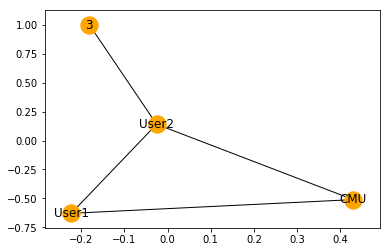

In [2]:
# We need this to show plots inside the notebook
%matplotlib inline

# Set a color for the nodes; useful if you have different types of nodes in one graph.
ORANGE = '#FFA500'

nx.draw_networkx(g, node_color=ORANGE, with_labels=True)

We can also play around with removing a node.

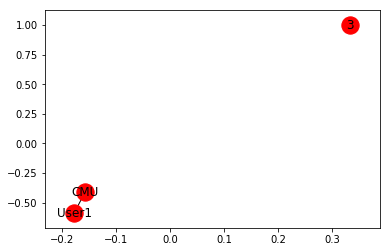

In [3]:
g.remove_node('User2')
nx.draw_networkx(g) # Will be red since we didn't specify the color

As you can see here, removing a node also deletes the edges connected to that node. We can re-add this node back manually if we want to, or we can simply add in edges.

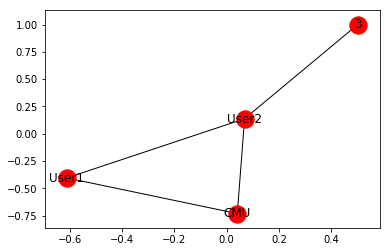

In [4]:
g.add_edges_from([('User1', 'User2'), ('User2', 'CMU'), ('User2', 3), ('User1', 'CMU')])
nx.draw_networkx(g)

## Loading in Twitter data

Data obtained from the Twitter API comes in JSON format, which we will be using in order to create notes and edges to develop a network. Since there are 30k+ tweets in this dataset, we first load the data into a JSON object.

In [5]:
import json

f = open('gifhistory.json')
data = json.load(f)

Next, we create a list of all of the users involved with the GifHistory thread. Since the Twitter data follows tweets with the hashtag #GifHistory, we don't actual have follower counts for each individual. Instead, we'll go through the data to see who is replying to who, and graph this using a directed graph.

In [6]:
tweetlist = data['tweets']

# Check length
print(len(tweetlist))

response_list = []

for tweet in tweetlist:
    user_name = tweet['user']['screen_name']
    reply_to = tweet['in_reply_to_screen_name']
    
    # Grab only the ones that are in reply to another tweet
    if reply_to != None:
        response_list.append((user_name, str(reply_to)))

# When we only look at tweets that involved a reply to another tweet,
# we only get 416 tweets... But this is more managable to graph for now.
print(len(response_list))
print(response_list[:20])

30813
416
[('meaghanfikes', 'MatthewACherry'), ('Todd_Gamez', 'MatthewACherry'), ('kclemson', 'ElJefeDSecurIT'), ('PunkRockMuppet', 'rachelamilligan'), ('ShirleyTSaint', 'MatthewACherry'), ('LookThatShitUp', 'MatthewACherry'), ('thomasmbalu', 'MatthewACherry'), ('ruggamontana', 'MatthewACherry'), ('bettycuckooper', 'MatthewACherry'), ('ash_pyle', 'MatthewACherry'), ('finchypoos', 'JonathanFinch7'), ('peterpanmisfit', 'MatthewACherry'), ('DeanRho', 'MatthewACherry'), ('Hotdog_Phingers', 'MatthewACherry'), ('dannyhall11', 'MatthewACherry'), ('anamaypipsqueek', 'MatthewACherry'), ('jacarsonfan', 'MatthewACherry'), ('4abregas', 'MatthewACherry'), ('stephliebold', 'MatthewACherry'), ('HowardTreesong', 'MatthewACherry')]


## Are replies useful to measure in our dataset?

Remember that MatthewACherry is the person who started this entire #GifHistory thread. It's not surprising that he features overwhelmingly in the tweets for the hashtag if this builds from his initial post. It's still very possible that we have influencers within the reply data, so let's see the connections in a graph.

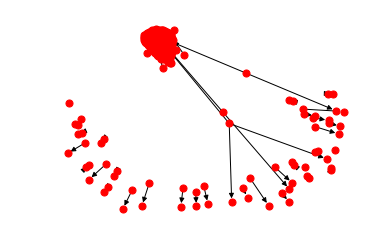

In [7]:
# Build a directed graph since replies are a direction from one node to another.
graph_reply = nx.DiGraph()

# Add edges from our list of tuples
graph_reply.add_edges_from(response_list)
plt.pyplot.axis('off')
    
nx.draw_networkx(graph_reply, with_labels=False, node_size=50)

Looks like with our data set, there are a cluster of replies to MatthewACherry and then a spread of individual replies.

## Exploring retweets of #GifHistory

Now that we know only a small subgroup of users in our dataset are replying to one main account, we can think of another way to analyze this dataset. Let's take a look at who's retweeting who in order to see the relations of users that are helping to spread the original tweet. This analysis is fairly intuitive; when we see threads expanding on Twitter, the number of retweets can be a strong measure of its virality.

Twitter defines retweet as follows: "A Retweet is a re-posting of a Tweet. Twitter's Retweet feature helps you and others quickly share that Tweet with all of your followers. You can Retweet your own Tweets or Tweets from someone else."

First, we do pre-processing to get all the data we need out of the JSON file.

In [8]:
import collections
    
# Create a dictionary of weights for later use
retweet_dict = set()
counts = collections.defaultdict(int)
    
for tweet in tweetlist: 
    
    # Check if the tweet is a retweet of another tweet
    if 'retweeted_status' in tweet:

        # User name of the original tweet
        orig_user_name = tweet['retweeted_status']['user']['screen_name']

        # User name of person retweeting
        rt_user_name = tweet['user']['screen_name']

        # Retweet count
        retweet_count = tweet['retweeted_status']['retweet_count']
        
        # Add each retweet relation to list
        retweet_dict.add((orig_user_name, str(rt_user_name)))
  
        counts[orig_user_name] += retweet_count

# Compare retweet relations with dictionary of those that have been retweeted
print(len(retweet_dict))
print(len(counts))

25667
110


Unsurprisingly, the majority of retweets are for the original starter of the thread. Since Twitter allows threads to continue from the original poster, it's not surprising that the spread of a hashtag involves a lot of retweets of the original tweet. What happens if we take away the original author of #GifHistory to look at smaller influencers in the network?

Name: 
Type: DiGraph
Number of nodes: 199
Number of edges: 205
Average in degree:   1.0302
Average out degree:   1.0302
0.005202781584691132


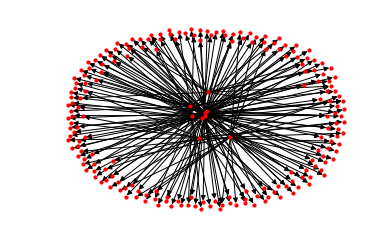

In [9]:
# Build a directed graph since retweets are a direction from one node to another.
graph_rt = nx.DiGraph()

for pair in retweet_dict:
    
    # Check if the tuple is a retweet of MatthewACherry
    if pair[0] != 'MatthewACherry' and counts[pair[0]] > 100:
        
        # Add node with attribute
        if counts[pair[0]] != False:
            graph_rt.add_node(pair[0], attr=counts[pair[0]])
        else:
            graph_rt.add_node(pair[0], attr=0)
        
        # Add nodes for retweeter
        graph_rt.add_node(pair[1], attr=0)
    
        # Add edges from our list of tuples
        graph_rt.add_edge(pair[0], pair[1])
        
# Going to take a while because we're trying to graph 29829 nodes.
plt.pyplot.axis('off')
nx.draw_networkx(graph_rt, with_labels=False, node_size=10)

# Let's get some info as well
print(nx.info(graph_rt))
# Higher density means more nodes are connected to one another
print(nx.density(graph_rt))

We haven't really done any programmatically complex analysis, and yet we're able to see that there are some users in this data set that actually are spreading the #GifHistory tag. In our next section, we're going to take a look at this subset of the data and try to identify which nodes are at the core of this subnetwork.

## Centrality measures of networks

Among our subset of data above, who are the users in the network that are influencing others the most outside of the person who started #GifHistory? Centrality aims to define the most important nodes of a system.

There are several different measures of centrality, and we explore three of them here.

1. Degree is defined as the sum of the edges for a specific node. Nodes with more edges may arguably be more important in our network, so this is one method of describing important users in our dataset.

2. Betweenness measures the number of times a node serves as a bridge in the shortest path between any other two nodes on the network. In other words, the sum of shortest paths that pass through a node. (NB: Our data set actually does not model betweenness very well due to the nature of the data structures. We're only loading in unidirectional relations between users from our dataset.)

3. Closeness measures the average of the lengths of the shortest paths that pass through a node. One way to think of this measure is similar to information spread. The more central a node is in terms of closeness, the faster it would be able to transmit information to all other nodes in the network.

However, just calculating the raw number of these measures would describe individual nodes in absolute measures and not relative ones. Thus, we normalize these numbers to create centrality measures of degree, betweenness, and closeness instead.

In [10]:
# Get the degree of nodes in a graph
degree = collections.Counter(graph_rt.degree())
print('Degrees per node: ', degree.most_common(5), '\n')
    
# Degree centrality
degree_cent = collections.Counter(nx.degree_centrality(graph_rt))
print('Degree centrality per node: ', degree_cent.most_common(5), '\n')

# Betweenness centrality (should output 0 for all members)
betweenness_cent = collections.Counter(nx.betweenness_centrality(graph_rt))
print('Betweenness centrality per node: ', betweenness_cent.most_common(5), '\n')

# Closeness centrality
closeness_cent = collections.Counter(nx.closeness_centrality(graph_rt))
print('Closeness centrality per node: ', closeness_cent.most_common(5))

Degrees per node:  [(('TKyle', 15), 1), (('marburymartian', 1), 1), (('Biographer1986', 13), 1), (('HandzJazz', 1), 1), (('veggie64_leslie', 2), 1)] 

Degree centrality per node:  [('IkeJae33', 0.2676767676767677), ('DanaGDill', 0.14141414141414144), ('WakeUpSooner', 0.14141414141414144), ('deadcatssociety', 0.10606060606060606), ('jenyamato', 0.10606060606060606)] 

Betweenness centrality per node:  [('TKyle', 0.0), ('marburymartian', 0.0), ('Biographer1986', 0.0), ('HandzJazz', 0.0), ('veggie64_leslie', 0.0)] 

Closeness centrality per node:  [('incolor___', 0.015151515151515152), ('PalaverSauce', 0.015151515151515152), ('Diva_Whoo', 0.015151515151515152), ('veggie64_leslie', 0.010101010101010102), ('teaba_g', 0.010101010101010102)]


We can also take our users with the most number of retweets and see if any of them tweet each other. Any outlier users are not being retweeted other members in the graph, but may be retweeted by even less central users.

[('d_andreaaaaa', 0.005452615833944215), ('Diva_Whoo', 0.005400096547497414), ('incolor___', 0.005355521985823378), ('Ceeeee__', 0.005273521612932462), ('Youlatoe', 0.005273521612932462)]


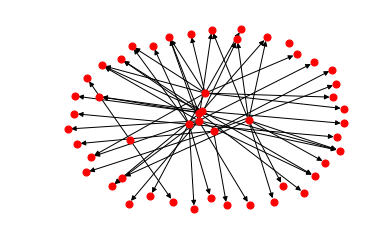

In [11]:
# List of 50 most retweeted users
high_degree = [user[0] for user in degree_cent.most_common(50)]

# Subgraph function allows us to gain edge data from list of nodes
sub_high = graph_rt.subgraph(high_degree)

plt.pyplot.axis('off')
nx.draw_networkx(sub_high, with_labels=False, node_size=50)

# Just for fun, we can try out PageRank on this subnetwork
top_five = collections.Counter(nx.pagerank(graph_rt,alpha=0.9)).most_common(5)
print(top_five)

Just for fun, let's see what gif these users in the subnetwork were asking the history of.

In [12]:
gifs = set()
total_tweets = 0

for tweet in tweetlist: 

    user_name = tweet['user']['screen_name']
    
    # Check if the user is in our top five users as a result of PageRank
    for name in top_five:
        if name[0] == user_name:
            total_tweets += 1
            # Check if the tweet is a retweet of another tweet
            if 'retweeted_status' not in tweet:
                gifs.add((name[0], tweet['full_text']))

print(total_tweets)
print(len(gifs))

60
0


Looks like among our top influencers according to PageRank, no user had an original tweet among their posts in the #GifHistory thread.

## Visualization

This section gives an introduction to formatting your own graph in NetworkX and how different graph algorithms might output different looking graphs. We will create a visualization using node sizes created from our retweet counts with modifications to change the size of nodes leading to nodes of users with a high retweet count.

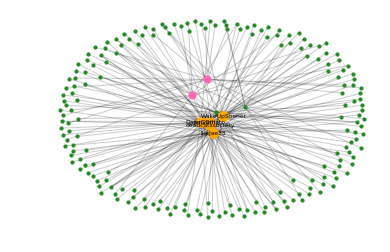

In [13]:
def graph_style(graph, style):
    
    # Allows us to use the same method for different styles
    if style == 'spring':
        style = nx.spring_layout(graph)
    elif style == 'circular':
        style = nx.circular_layout(graph)
    elif style == 'fruchterman_reingold':
        style = nx.fruchterman_reingold_layout(graph)
    elif style == 'random':
        style = nx.random_layout(graph)
    elif style == 'shell':
        style = nx.shell_layout(graph)
    elif style == 'spectral':
        style = nx.spectral_layout(graph)
    
    # Completely aribitrary split of all nodes into categories for visualization purposes
    big_nodes = []
    med_nodes = []
    small_nodes = []
    users = {}
    
    # Redraw the nodes of our original graph 
    for user, d in graph.nodes(data=True):
        
        if d['attr'] > 500:
            big_nodes.append(user)
            users[user]=user
        if 200 < d['attr'] <= 500:
            med_nodes.append(user)
        if d['attr'] <= 200 :
            small_nodes.append(user)
    
    edges = [edge for edge in graph.edges()]

    # Apply unique modifiers to the lists of nodes
    plt.pyplot.axis('off')
    nx.draw_networkx_nodes(graph, style, nodelist=big_nodes, node_size=100, node_color='#FFA500')
    nx.draw_networkx_nodes(graph, style, nodelist=med_nodes, node_size=50, node_color='#FF69B4')
    nx.draw_networkx_nodes(graph, style, nodelist=small_nodes, node_size=10, node_color='#228B22')
    nx.draw_networkx_edges(graph, style, edgelist=edges, arrows=False, width=1, alpha=0.2, edge_color='#000000')
    nx.draw_networkx_labels(graph, style, users, font_size=6)

graph_style(graph_rt, 'spring')

We finally have a graph that gives us an idea of the topology of our subnetwork within #GifHistory. The orange dots are users who were retweeted over 40 times, the pink dots are users who were retweeted 100 or fewer times, and the remaining green dots are those who were retweeted 0 times. 

It's hard to say much more about the nature of our subnetwork regarding orange and pink influencers other than their distribution does not cluster into groups. That is, there seems to be no discernable communities in this subnetwork of retweets. However, what's interesting to note are some of the smaller green dots in the middle. These dots show users who have been retweeted less, but nonetheless have been retweeted by one or two other users in our subnetwork.

## Summary and references

Although much of this introduction to NetworkX has focused on some of the more basic functionality in the library, I hope that walking through the logic of importing social media data and attempting a few analyses will be useful to others in the class. Please see the references below.

1. NetworkX: https://networkx.github.io/documentation/stable/index.html
2. Twitter API Documentation: https://developer.twitter.com/en/docs
3. UC Riverside Dash: https://dash.ucr.edu
4. George Washing University Twitter Data Guide: https://gwu-libraries.github.io/sfm-ui/posts/2017-09-14-twitter-data
6. Social Network Analysis on Wikipedia: https://en.wikipedia.org/wiki/Social_network_analysis
7. Social Network Analysis: Centrality Measures (Donglei Du, University of New Brunswick): http://www2.unb.ca/~ddu/6634/Lecture_notes/Lecture_4_centrality_measure.pdf
8. The Programming Historian: https://programminghistorian.org/lessons/exploring-and-analyzing-network-data-with-python#fnref:averagedegree